# Vector Space Semantics for Similarity between Eastenders Characters




In [1]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tag import CRFTagger

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

%matplotlib inline
pd.options.display.max_colwidth=500

In [2]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
all_train_data = pd.read_csv(train_path, skip_blank_lines = True, header=None, names=['Line','Character','Gender'])
test_path ='test.csv'
test_data = pd.read_csv(test_path, skip_blank_lines = True, header=None, names=['Line','Character','Gender'])

# Inspect
all_train_data

,Line,Character,Gender
0,Someone had fun.,SEAN,male
1,"It's no problem, honestly. Go on, go and open the launderette. Leave it with me.",SHIRLEY,female
2,Last night was better than ever. What's all this? Anything interesting?,MAX,male
3,Have you checked the answerphone? Any calls?,IAN,male
4,Oscar's asleep.,MAX,male
...,...,...,...
10108,"What's going on Gal? What's going on? I don't understand mate. You said you were gonna go and get her, you promised...",MINTY,male
10109,Am I mad? Have I completely lost it?,TANYA,female
10110,You're late.,JACK,male
10111,Ask your psycho Ex.,ROXY,female


In [3]:
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split
print('Raw Data: ',np.shape(all_train_data))
idx = int(0.9 * np.shape(all_train_data)[0])
train_data = all_train_data[:idx]
val_data = all_train_data[idx:]
print('Train set: ',np.shape(train_data))
print('Validation set: ',np.shape(val_data))

Raw Data:  (10113, 3)
Train set:  (9101, 3)
Validation set:  (1012, 3)


In [4]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):

    character_docs = {}
    character_line_count = {}
    for line, name, gender in zip(df.Line, df.Character, df.Gender):
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        character_docs[name] += str(line)   + " _EOL_ "  # adding an end-of-line token
        character_line_count[name]+=1
    print("lines per character", character_line_count)
    return character_docs

In [5]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'SEAN': 360, 'SHIRLEY': 360, 'MAX': 360, 'IAN': 360, 'MINTY': 360, 'RONNIE': 360, 'STACEY': 360, 'JANE': 360, 'PHIL': 360, 'CLARE': 359, 'TANYA': 360, 'HEATHER': 360, 'GARRY': 308, 'BRADLEY': 292, 'CHRISTIAN': 357, 'STEVEN': 268, 'ROXY': 360, 'JACK': 360}
Num. Characters:  18 

SEAN Number of Words:  3629
SHIRLEY Number of Words:  4023
MAX Number of Words:  4627
IAN Number of Words:  4165
MINTY Number of Words:  3914
RONNIE Number of Words:  3528
STACEY Number of Words:  3979
JANE Number of Words:  3818
PHIL Number of Words:  3950
CLARE Number of Words:  4311
TANYA Number of Words:  4092
HEATHER Number of Words:  4040
GARRY Number of Words:  3599
BRADLEY Number of Words:  2865
CHRISTIAN Number of Words:  3979
STEVEN Number of Words:  2485
ROXY Number of Words:  3824
JACK Number of Words:  4110
total words 68938


In [6]:
def pre_process(character_text):

    string.punctuation

    # word tokenisation
    Text = character_text
    Text = Text.strip(string.punctuation)
    Text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", Text) #separating words and special charaters from words that comes after the word
    Text = re.sub(r"([.,;:!?'\"“\(])(\w)", r"\1 \2", Text) #separating words and special charaters from words that comes before the word
    Text =  re.sub(r'[^\w\s]','',Text)
    Text = re.sub(r'\_','',Text)
    tokens = re.split(r"\s+",Text)   #tokenize(split on white space)
    
    # normalisation
    tokens = [t.lower() for t in tokens]   #lower casing the words
    
#     # stopword removal
    stop = set(stopwords.words('english'))  #instantiate stop object that contains all the stopwords
    tokens = [t for t in tokens if t not in stop]  #removes stopwords from sentence
    
    return tokens

In [7]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]


In [8]:
def to_feature_vector_dictionary(character_doc, extra_features=[]):
   
    posttagger = CRFTagger()
    posttagger.set_model_file("crf_pos.tagger")
    tagged = posttagger.tag(character_doc) 
    
    localFeat = {}         #Local dictionary
    
############### Simple word count ###############
#################################################

    for words in character_doc:
        try:
            localFeat[words] += (1.0/len(character_doc)) #Tries adding the weights to existing tokens that's been calculated
        except KeyError:
            localFeat[words] = (1.0/len(character_doc)) #If error, code will exucute this line and add the word to dictionary

######### Adding word as keys and postags as features #################
#######################################################################
    
#     for word in tagged:           
#         localFeat[word[0]] = (word[1]) #Adding word as keys and postags data

#######################################################################

#     counts = Counter(character_doc)  # for now a simple count
#     localFeat = dict(counts)

    # add the extra features, for now just adding one count for each extra feature
#     for feature in extra_features:
#         counts[feature] += 1

    return (localFeat)



In [9]:
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here
corpusVectorizer2 = TfidfTransformer()  # initializing the tf-idf transformer

def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc) for name, doc in corpus])
    
    corpusVectorizer2.fit(doc_feature_matrix)         # fitting the idf vector
    doc_feature_matrix = corpusVectorizer2.transform(doc_feature_matrix) #Transform a count matrix to a tf or tf-idf representation
    
    return (doc_feature_matrix)

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

In [10]:
training_feature_matrix

<18x4361 sparse matrix of type '<class 'numpy.float64'>'
	with 12706 stored elements in Compressed Sparse Row format>

In [11]:
# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character {'IAN': 40, 'STACEY': 40, 'JANE': 40, 'SEAN': 40, 'CLARE': 40, 'MAX': 40, 'TANYA': 40, 'JACK': 40, 'SHIRLEY': 40, 'RONNIE': 40, 'MINTY': 39, 'GARRY': 32, 'STEVEN': 30, 'BRADLEY': 40, 'ROXY': 40, 'CHRISTIAN': 40, 'HEATHER': 40, 'PHIL': 40}
Num. Characters:  18 

IAN Num of Words:  611
STACEY Num of Words:  409
JANE Num of Words:  503
SEAN Num of Words:  414
CLARE Num of Words:  512
MAX Num of Words:  411
TANYA Num of Words:  399
JACK Num of Words:  434
SHIRLEY Num of Words:  419
RONNIE Num of Words:  362
MINTY Num of Words:  555
GARRY Num of Words:  387
STEVEN Num of Words:  312
BRADLEY Num of Words:  509
ROXY Num of Words:  376
CHRISTIAN Num of Words:  517
HEATHER Num of Words:  543
PHIL Num of Words:  411
total words 8084


In [12]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [13]:
val_feature_matrix

<18x4361 sparse matrix of type '<class 'numpy.float64'>'
	with 2328 stored elements in Compressed Sparse Row format>

In [14]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [15]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [16]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

mean rank 1.2222222222222223
mean cosine similarity 0.7886219011638052
15 correct out of 18 / accuracy: 0.8333333333333334


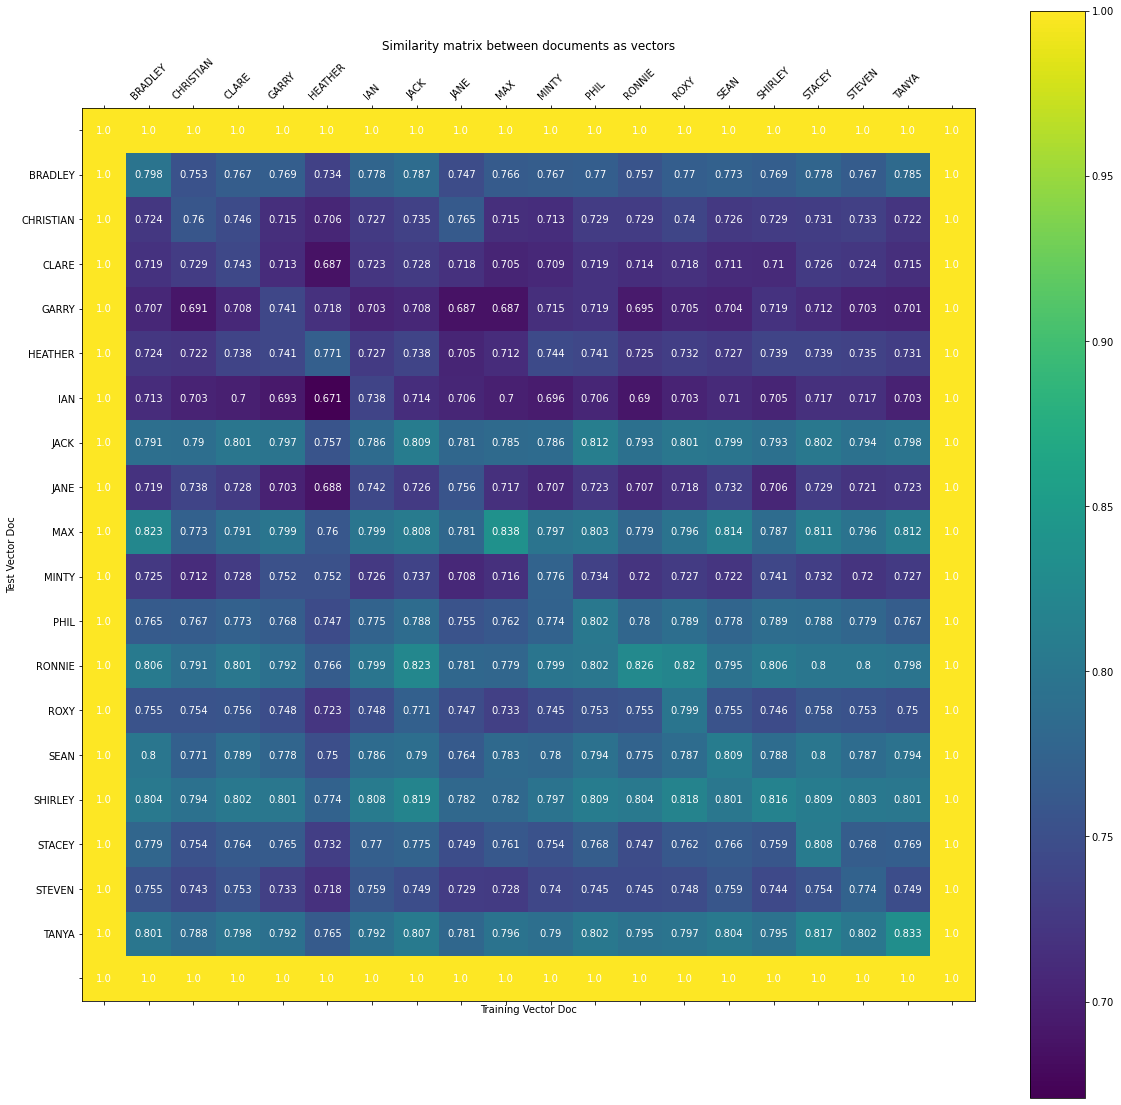

In [17]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
plot_heat_map_similarity(df)

In [18]:
# redo on all training data with the first 400 character lines used
train_character_docs = create_character_document_from_dataframe(all_train_data, max_line_count=400)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = DictVectorizer()   # initialize a corpusVectorizor which will output sparse vectors from dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here
corpusVectorizer2 = TfidfTransformer()


training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=40)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
test_corpus = [(name, pre_process(doc)) for name, doc in test_character_docs.items()]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

lines per character {'SEAN': 400, 'SHIRLEY': 400, 'MAX': 400, 'IAN': 400, 'MINTY': 400, 'RONNIE': 400, 'STACEY': 400, 'JANE': 400, 'PHIL': 400, 'CLARE': 400, 'TANYA': 400, 'HEATHER': 400, 'GARRY': 340, 'BRADLEY': 332, 'CHRISTIAN': 397, 'STEVEN': 298, 'ROXY': 400, 'JACK': 400}
Num. Characters:  18 

SEAN Number of Words:  3949
SHIRLEY Number of Words:  4427
MAX Number of Words:  5098
IAN Number of Words:  4730
MINTY Number of Words:  4374
RONNIE Number of Words:  3903
STACEY Number of Words:  4370
JANE Number of Words:  4154
PHIL Number of Words:  4322
CLARE Number of Words:  4837
TANYA Number of Words:  4605
HEATHER Number of Words:  4484
GARRY Number of Words:  3986
BRADLEY Number of Words:  3374
CHRISTIAN Number of Words:  4496
STEVEN Number of Words:  2797
ROXY Number of Words:  4196
JACK Number of Words:  4564
total words 76666
lines per character {'STACEY': 40, 'RONNIE': 40, 'STEVEN': 37, 'TANYA': 40, 'MAX': 40, 'ROXY': 40, 'IAN': 40, 'JANE': 40, 'JACK': 40, 'CLARE': 31, 'PHIL': 4

# Results

# Q1

In [ ]:
#For preprocessing, I removed punctuations, nummbers and stopwords.
#The mean rank improved significantly with the removal of stopwords.
#Below shows the result without removing stopwords and removing stopwords.

######## Without removing stopwords ###############################
###################################################################

# mean rank 2.2222222222222223
# mean cosine similarity 0.9328635459565423
# 10 correct out of 18 / accuracy: 0.5555555555555556

######## After stopwords is removed #####################################
#########################################################################

# mean rank 1.2222222222222223
# mean cosine similarity 0.9450616080703619
# 14 correct out of 18 / accuracy: 0.7777777777777778


## Comments
## The best result is obtained after removing stopwords from the sentences
## A mean rank of 1.22 and an accuracy of 0.78 is achieved 

# Q2

In [ ]:
#For feature extraction, I attempted used simple weighted word count, postags

## Result of simple word count ## 
#################################

# mean rank 1.2222222222222223
# mean cosine similarity 0.9450616080703621
# 14 correct out of 18 / accuracy: 0.7777777777777778

###############################################################################################################################

## Adding word as keys and postags as features ##
#################################################

# mean rank 3.0555555555555554
# mean cosine similarity 0.20331164261511173
# 6 correct out of 18 / accuracy: 0.3333333333333333

###############################################################################################################################

################# Combining simple word count and postags #######################
#################################################################################

# mean rank 3.0555555555555554
# mean cosine similarity 0.20331164261511173
# 6 correct out of 18 / accuracy: 0.3333333333333333

###############################################################################################################################



# Q3

In [ ]:
## Implemented tf-idf in the create_document_matrix_from_corpus function

# mean rank 1.2222222222222223
# mean cosine similarity 0.7886219011638052
# 15 correct out of 18 / accuracy: 0.8333333333333334

## Comments
## After adding the tf-idf transform in the create_document_matrix_from_corpus, the mean rank maintained at 1.22
## however, the accuracy increased to 0.83.


# Q4

In [ ]:
## Using the best combination of techniques, the result on the testing data is as shown below..

# mean rank 1.1111111111111112
# mean cosine similarity 0.8040637422459219
# 17 correct out of 18 / accuracy: 0.9444444444444444

## Comments
## The mean rank on test data is 1.11, improved from the validation set of 1.22.
## The accuracy also increased to 0.94 compared to 0.83 on the validation set.
